<font size=+4 color="Black"><center><b>EDA & Viz for Covid-19 tweets</b></center></font>
<font size=-1 color="Black"><center><b>* preprocessing & modeling to follow</b></right></font>

<font size="+2" color="Red"><b>Please Upvote if you like the work</b></font>

### It gives motivation to a working professional (like me) to contribute more.

# **About this notebook:**



![](https://media1.tenor.com/images/ed7cffc243c6a6ffe63058e79d1ea0ac/tenor.gif?itemid=16735375)


This notebook aims at presenting EDA & Viz on Covid-19 tweets. The emphasis has been on the text (tweets) and its in-depth analysis for pre-processing. The modeling will be done in a separate notebook.
This notebook is prepared on the Covid-19 tweets which are tagged manually from Highly Negative to Highly Positive - i.e. five classes. In this EDA we will change them to 3 classes (Positive, Negative & Neutal).

Contents:

* [1. Data](#1)
* [2. Class Distribution](#2)
* [3. Number of characters](#3)
* [4. Number of words in a tweet](#4)
* [5. Avg. word length in a tweet](#5)
* [6. Common Stop-words](#6)
* [7. Punctuations](#7)
* [8. Common words](#8)
* [9. Hashtagss](#9)
* [10. Mentions](#10)
* [11. Basic pre-processing](#11)
* [12. Wordclouds](#12)
* [13. N-grams](#13)




In [1]:
!pip install textstat

     |████████████████████████████████| 102 kB 395 kB/s ta 0:00:011
     |████████████████████████████████| 3.0 MB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Let's get started..........
![](https://habrastorage.org/webt/t6/sr/jr/t6srjrmjjmm6qn8gpld9emy4txu.gif)

<a id="1"></a>
    
<font size="+2" color="indigo"><b>1. Data</b></font><br>

In [3]:
train=pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')



df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print("\n")
print(train.head())
print("\n")
print(train.info())

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


   UserName  ScreenName   Location     TweetAt                                      OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      3800       48752         UK  16-03-2020  advice Talk to your neighbours family to excha...            Positive
2      3801       48753  Vagabonds  16-03-2020  Coronavirus Australia: Woolworths to give elde...            Positive
3      3802       48754        NaN  16-03-2020  My food stock is not the only one which is emp...            Positive
4      3803       48755        NaN  16-03-2020  Me, ready to go at supermarket during the #COV...  Extremely Negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  -----

In [5]:
# Drop duplicates
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (44955, 6)


In [6]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)


Null Values in each column:
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1      Sentiment              0         0.000000
2  OriginalTweet              0         0.000000
3        TweetAt              0         0.000000
4     ScreenName              0         0.000000
5       UserName              0         0.000000


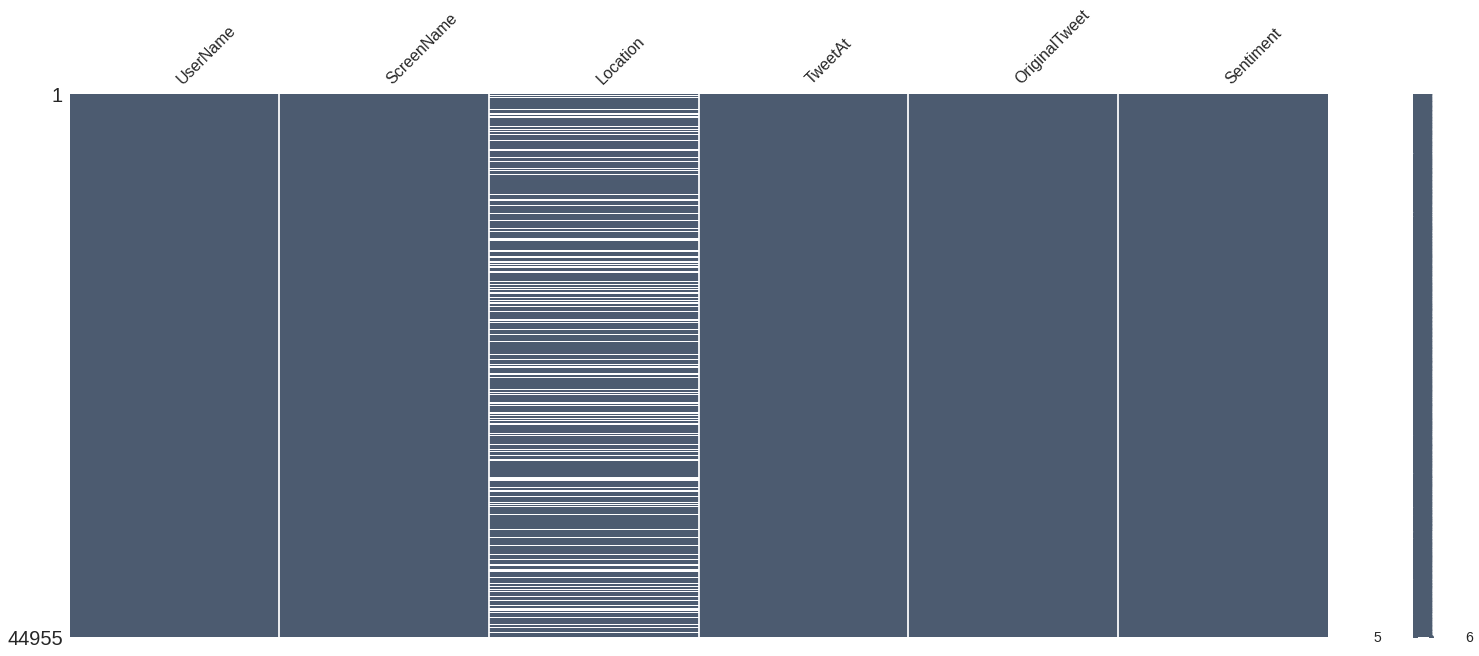

In [7]:
#Missing data as white lines 
import missingno as msno
msno.matrix(df,color=(0.3,0.36,0.44))

#### Null values in location

In [8]:
print('Total tweets in this data: {}'.format(df.shape[0]))
print('Total Unique Users in this data: {}'.format(df['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


In [9]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [10]:
# We will copy the text in another column so that the original text is also there for comparison

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)
    

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

# EDA, Metafeatures & Viz

<a id="2"></a>
    
<font size="+2" color="indigo"><b>2. Class Distribution</b></font><br>


In [11]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


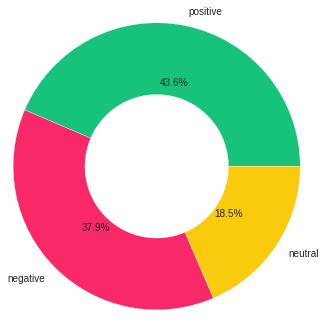

In [12]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()



### There is uneven distribution of classes with positive taking the largest of pie followed by negative.
## The colors used above will represent the classes ahead.

In [13]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

#### Same pattern of uneven distribution in both train and test data



<a id="3"></a>
    
<font size="+2" color="indigo"><b>3. Number of characters</b></font><br>


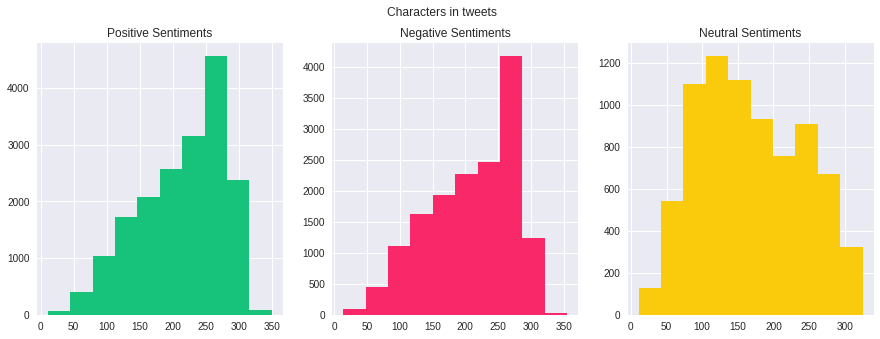

In [14]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

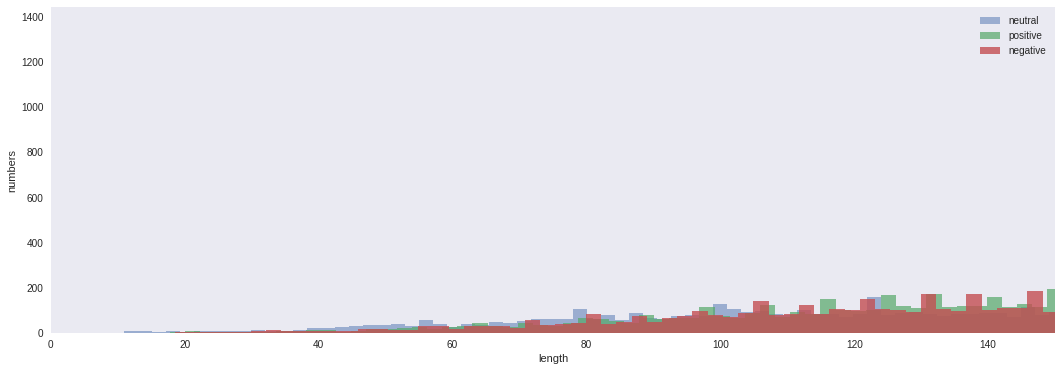

In [15]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()



<a id="4"></a>
    
<font size="+2" color="indigo"><b>4. Number of words in a tweet</b></font><br>





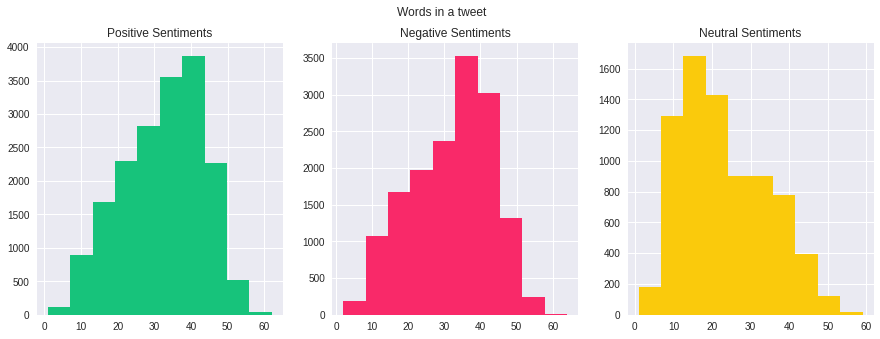

In [16]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()



<a id="5"></a>
    
<font size="+2" color="indigo"><b>5. Average word length in a tweet</b></font><br>






Text(0.5, 0.98, 'Average word length in each tweet')

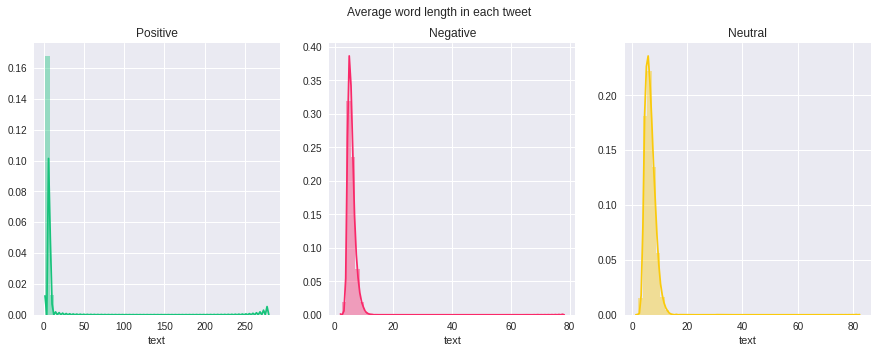

In [17]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')



<a id="6"></a>
    
<font size="+2" color="indigo"><b>6. Common Stopwords in the tweets</b></font><br>



In [18]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
np.array(stop)

array({'such', "hadn't", 'needn', 'same', 'where', 'were', 'over', 'now', 'if', "you'll", 'very', 'he', 'its', 'haven', "mightn't", 's', 'did', 'up', 'was', 'in', 'themselves', 'wouldn', 'how', 'which', "couldn't", 'll', 'd', 'she', 'we', 'what', 'i', 'on', 'didn', 'there', 'who', 'don', 'of', 'isn', 'an', 'couldn', 'had', 'before', "shan't", 'own', 'here', 'off', 'their', 've', 'until', 'both', 'o', 'his', 'being', 'than', "didn't", 'a', 'not', 'himself', 'shan', "should've", 'this', 'm', "wasn't", 'are', 'above', 'have', 'they', 'no', 'by', 'other', 'weren', "hasn't", 'it', 'for', 't', 'hers', 'down', "aren't", 'is', 'itself', "you're", 'been', 'that', 'him', 'out', 'the', 'yourselves', 'then', "mustn't", 'at', "you've", 'as', 'our', 'during', 'will', 'few', 'once', 'most', "you'd", 'ain', 'into', 'yourself', 'only', 'shouldn', 'you', 'to', "doesn't", 'wasn', 'doesn', 'ourselves', 'theirs', 'about', 'while', 'am', 'because', 'below', 'further', "haven't", 'through', 'me', 'do', 'with

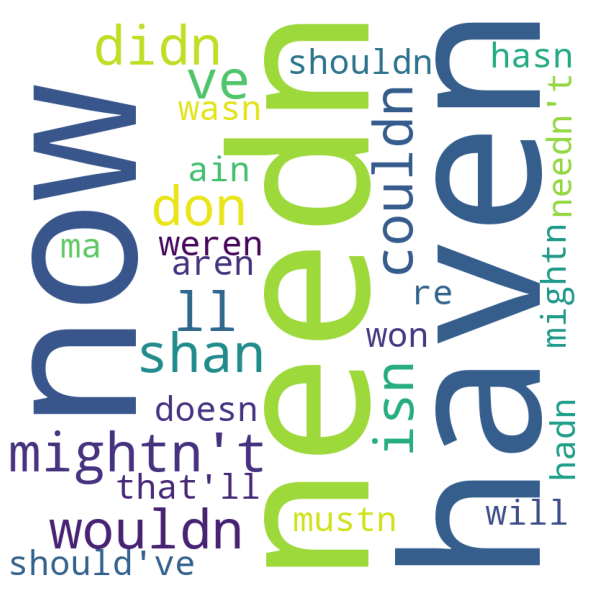

In [20]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<BarContainer object of 10 artists>

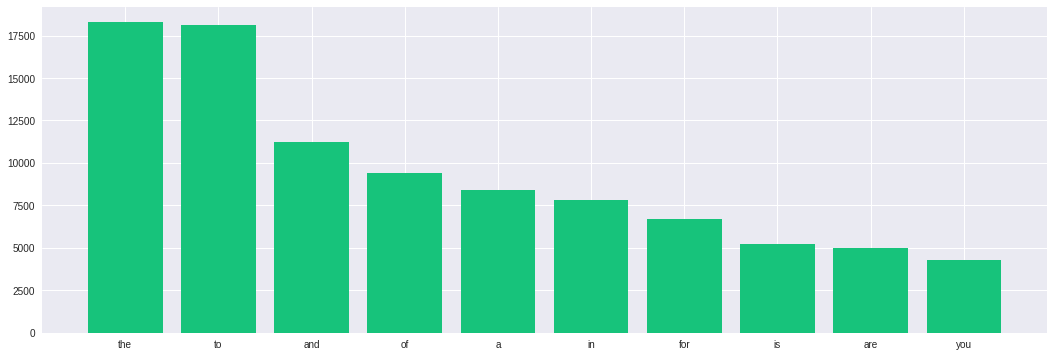

In [21]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

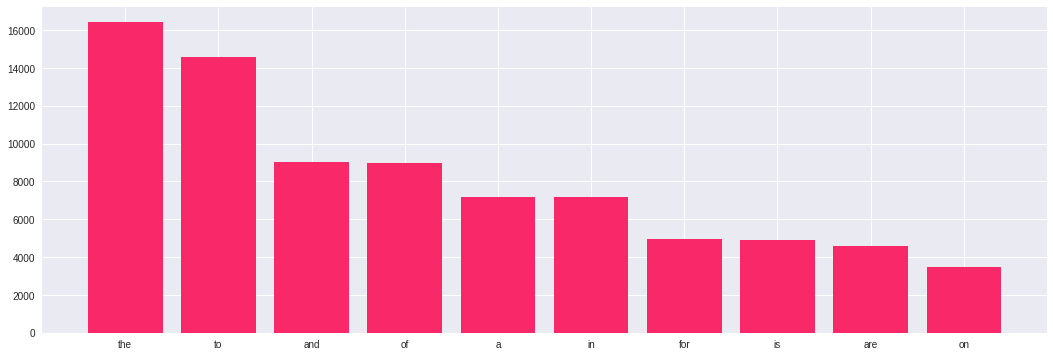

In [22]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

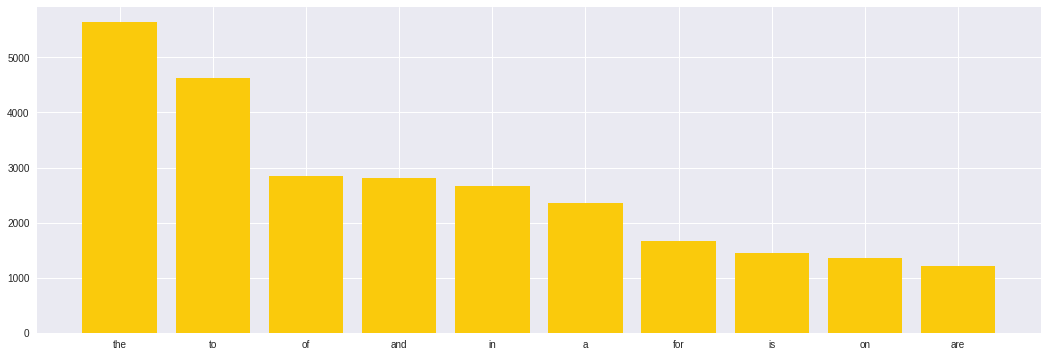

In [23]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

#### A lot stopwords are present. Require preprocessing



<a id="7"></a>
    
<font size="+2" color="indigo"><b>7. Punctuations</b></font><br>

 




<BarContainer object of 27 artists>

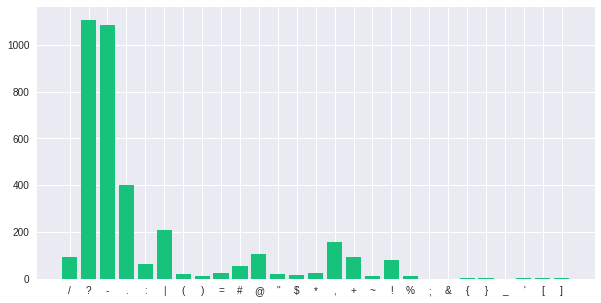

In [24]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 25 artists>

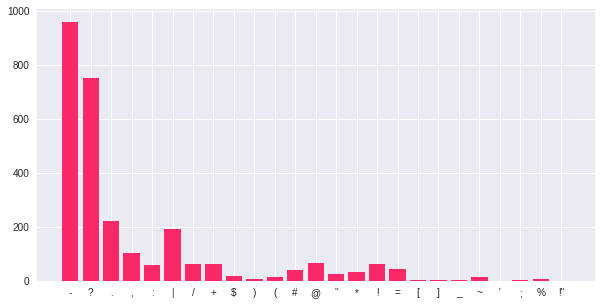

In [25]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 23 artists>

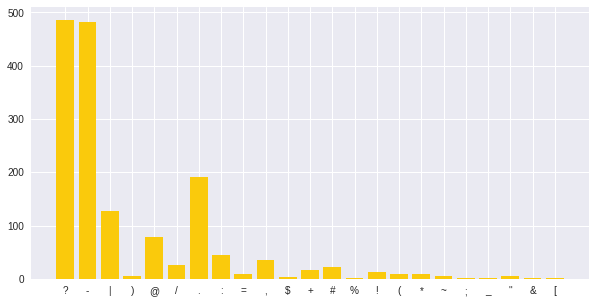

In [26]:
plt.figure(figsize=(10,5))
corpus=create_corpus("neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

#### More cleaning to be done



<a id="8"></a>
    
<font size="+2" color="indigo"><b>8. Common Words</b></font><br>



In [27]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

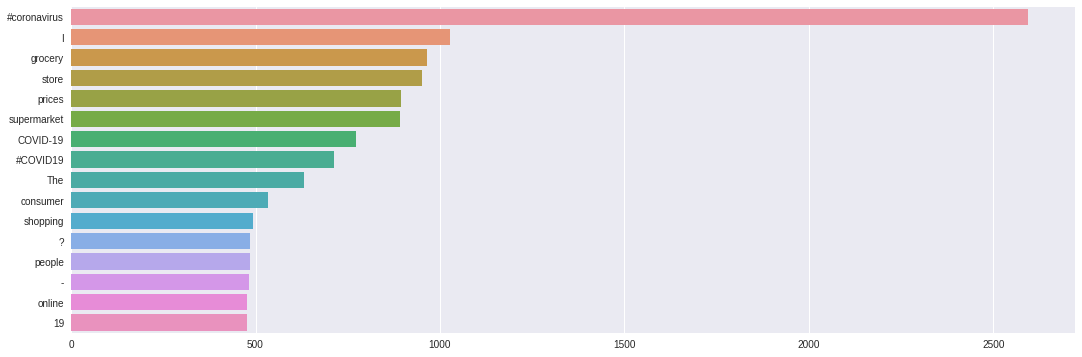

In [28]:
sns.barplot(x=y,y=x)

#### Common words feature punctuations, we need extensive data cleaning



<a id="9"></a>
    
<font size="+2" color="indigo"><b>9. Hashtags</b></font><br>


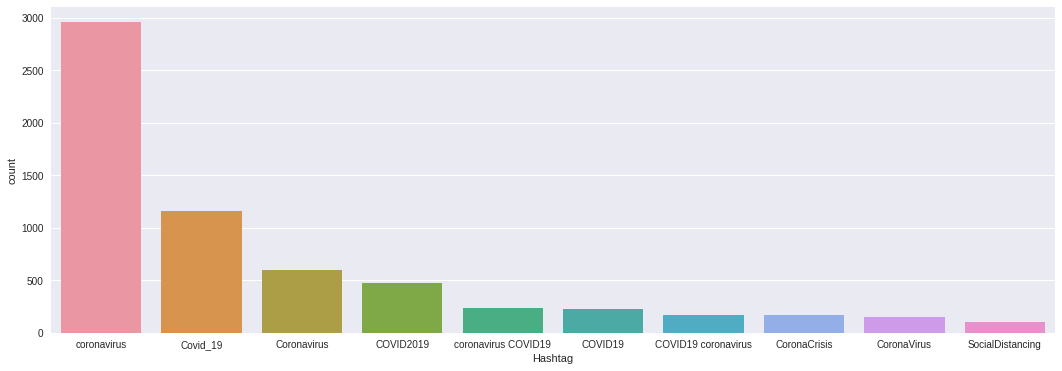

In [29]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

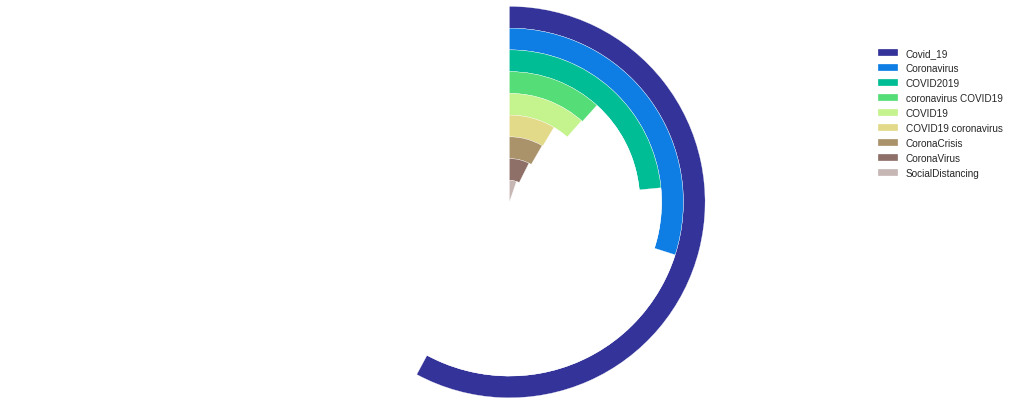

In [30]:
from matplotlib import cm
from math import log10

labels = df['hash'].value_counts()[:][2:11].index.tolist()
data = df['hash'].value_counts()[:][2:11]

df['hash'].value_counts()[:][1:11].index.tolist()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

#### While lower casing is required, we can see that hashtags contain keywords related to coronavirus 



<a id="10"></a>
    
<font size="+2" color="indigo"><b>10. Mentions</b></font><br>



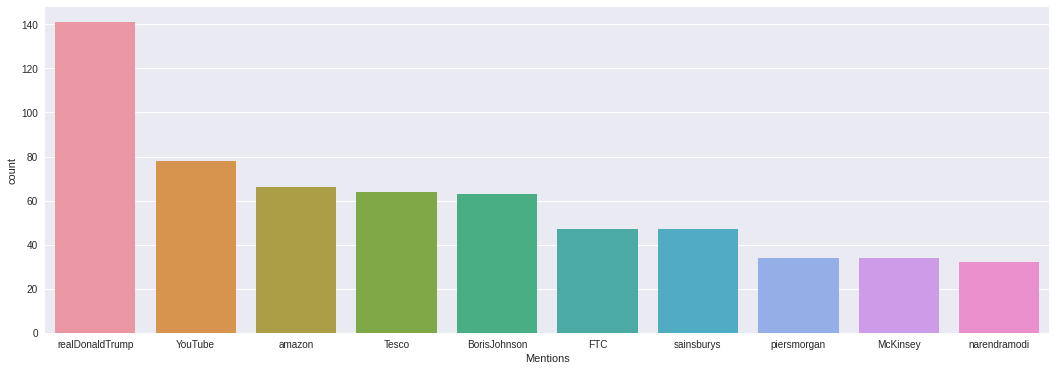

In [31]:

def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)

In [32]:
b = df['mentions'].value_counts()[:][1:11].index.tolist()
a = df['mentions'].value_counts()[:][1:11].tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Mentions')
fig.show()



<a id="11"></a>
    
<font size="+2" color="indigo"><b>11. Pre-processing</b></font><br>



In [33]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new']=df['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text_new'].apply(lambda x:remove_html(x))



In [34]:

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['text_new']=df['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['text']=df['text_new'].apply(lambda x:remove_num(x))



In [35]:

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['text_new']=df['text'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text']=df['text_new'].apply(lambda x:remove_stopwords(x))



In [36]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text_new']=df['text'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text']=df['text_new'].apply(lambda x:remove_hash(x))


In [37]:

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['text_new']=df['text'].apply(lambda x:remove_space(x))

df = df.drop(columns=['text_new'])



<a id="12"></a>
    
<font size="+2" color="indigo"><b>12. Wordclouds</b></font><br>


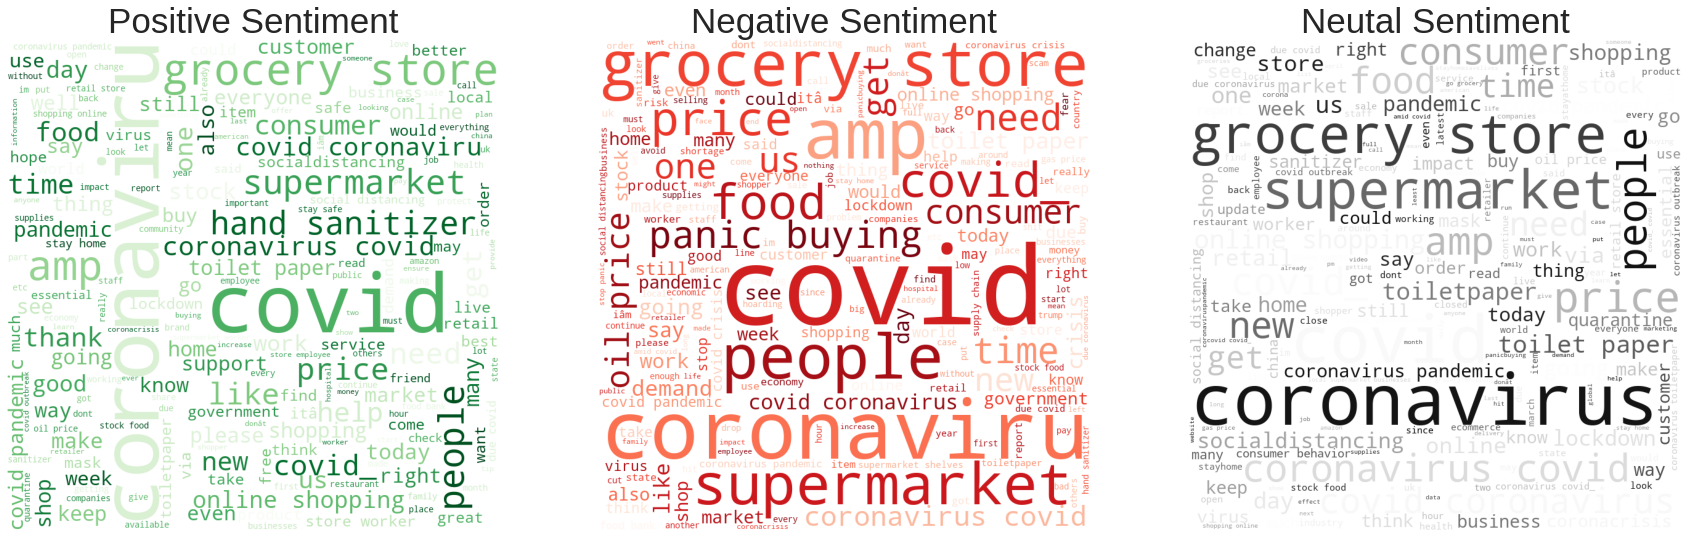

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["sentiment"]=="positive"]
df_neg = df[df["sentiment"]=="negative"]
df_neu = df[df["sentiment"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [39]:
del df_pos
del df_neg
del df_neu



<a id="13"></a>
    
<font size="+2" color="indigo"><b>13. N-grams</b></font><br>


## Unigrams

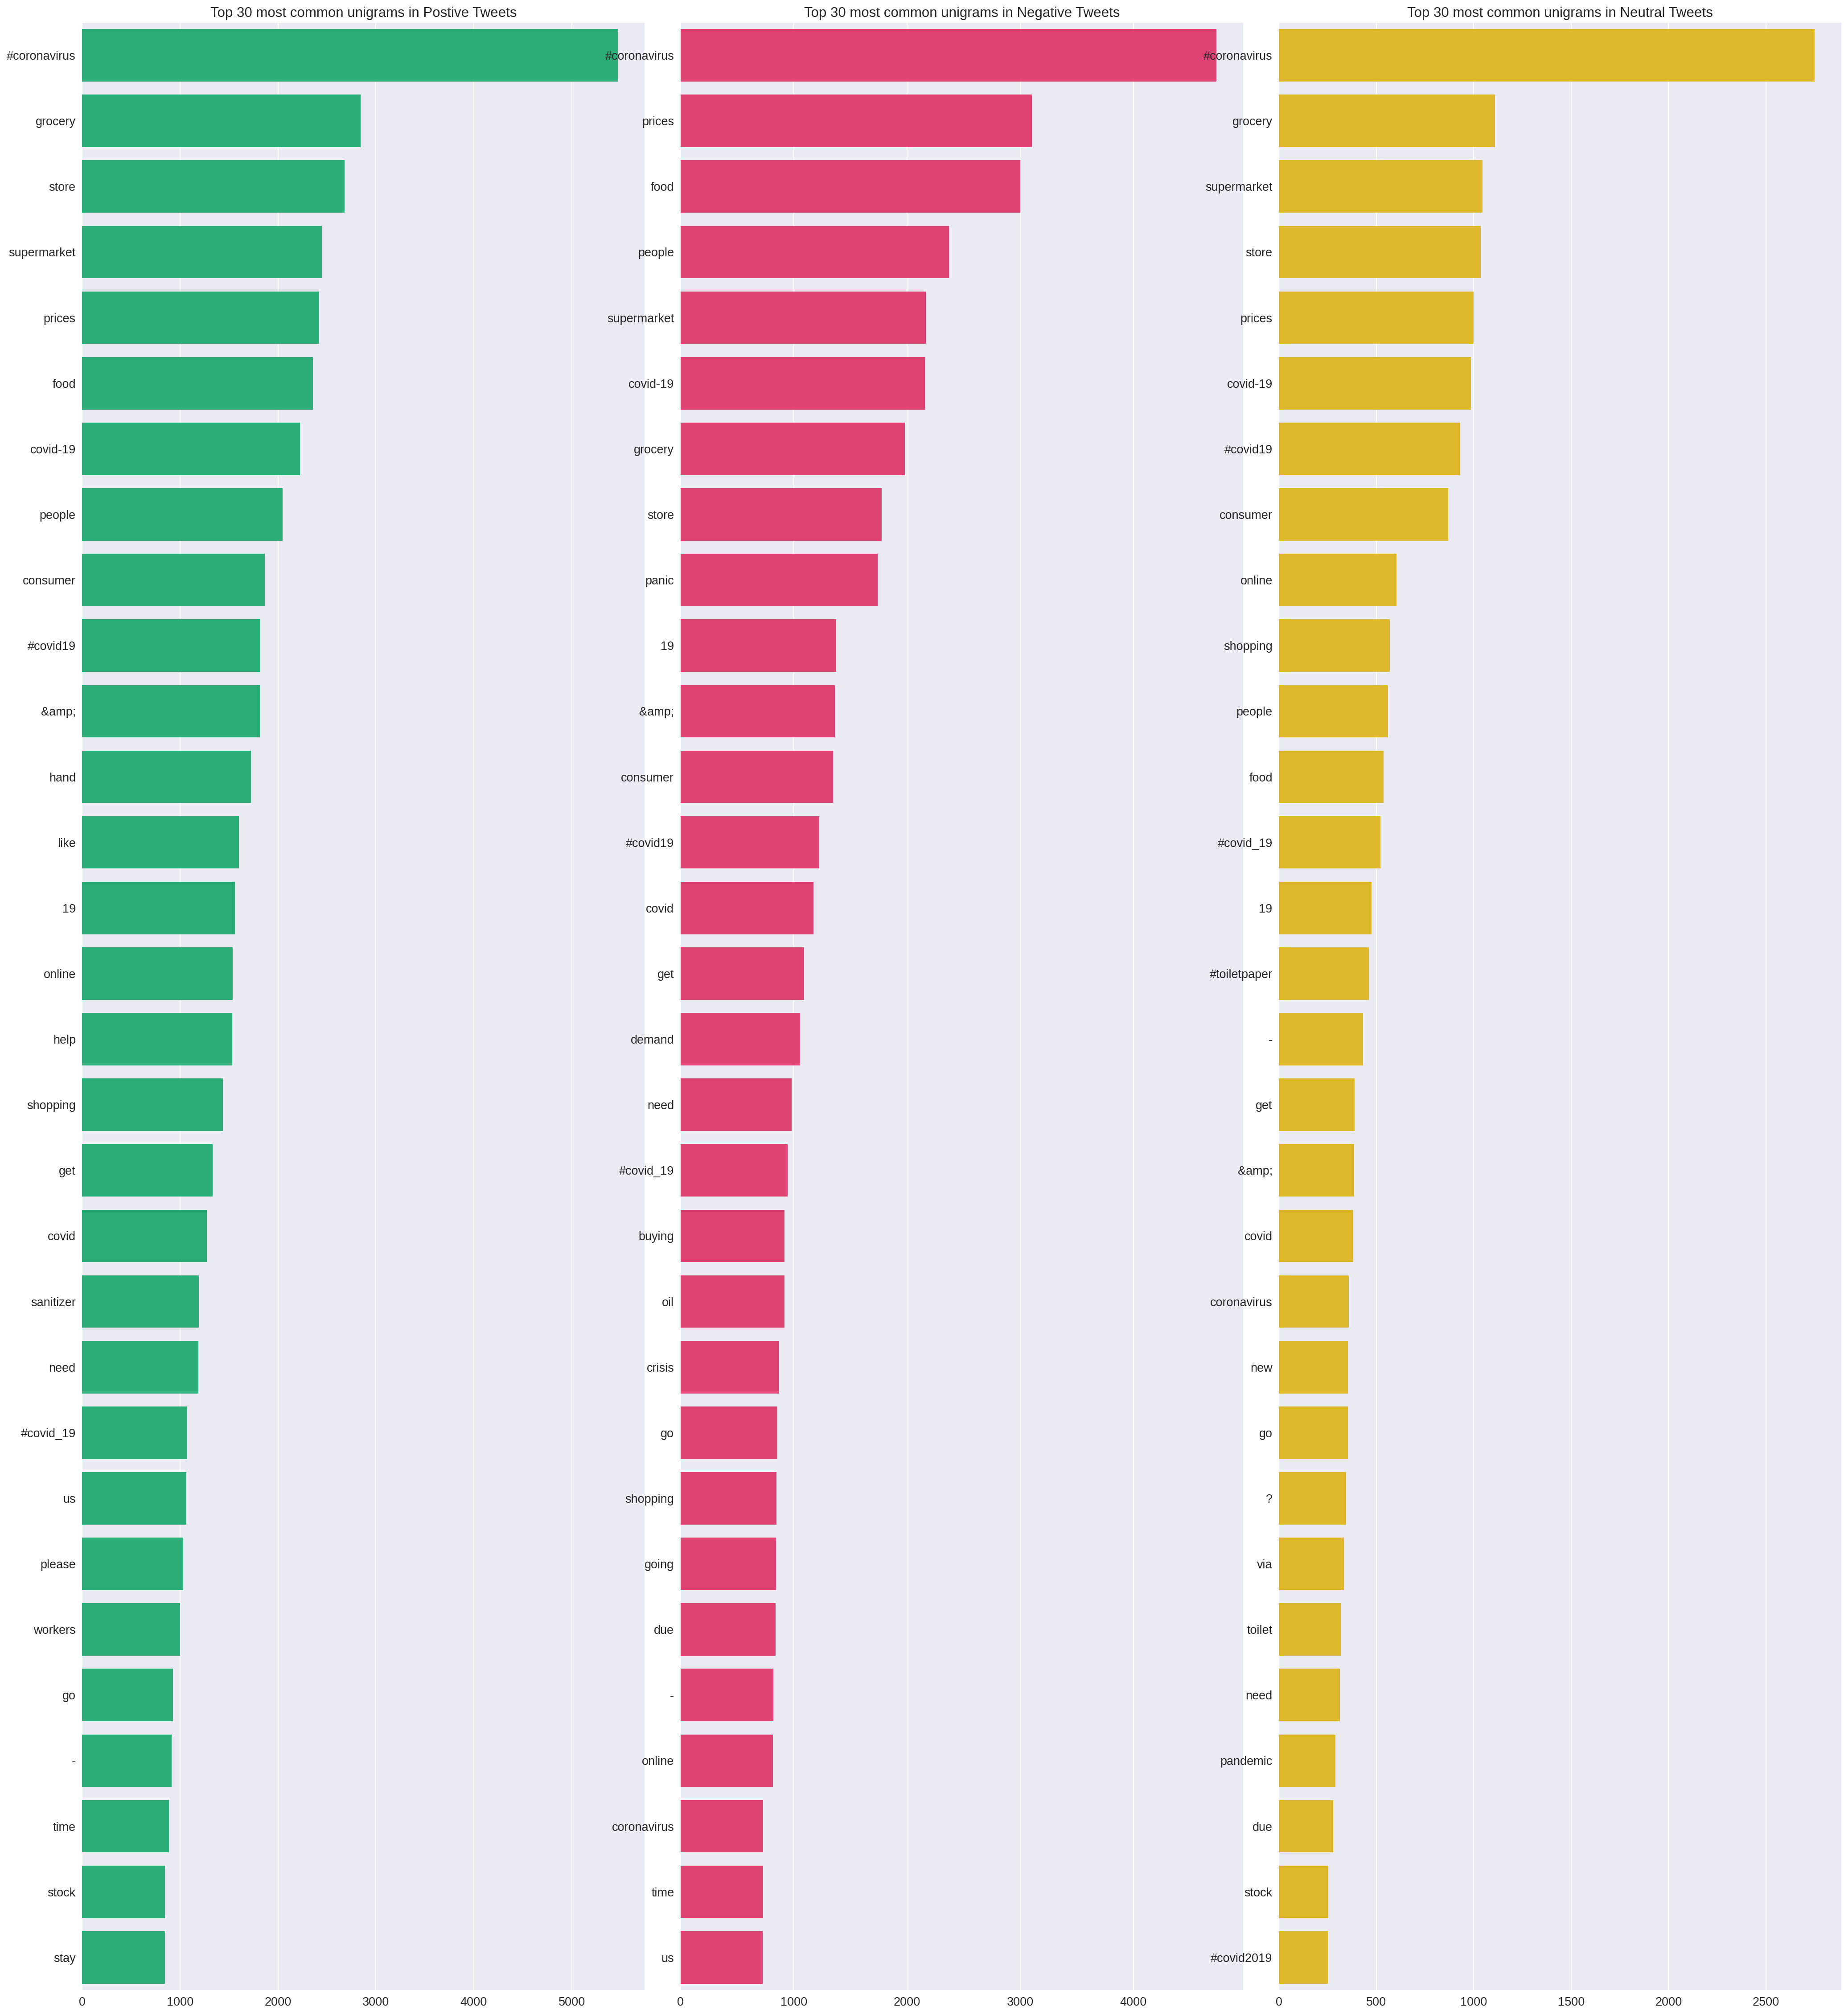

In [40]:
# Define functions
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30



positive= train["sentiment"]== "positive"
negative= train["sentiment"]== "negative"
neutral= train["sentiment"]== "neutral"

positive_unigrams = defaultdict(int)
neutral_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Unigrams
for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet):
        neutral_unigrams[word] += 1        
        
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_unigrams[0].values[:N], x=df_neutral_unigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

## Bi grams

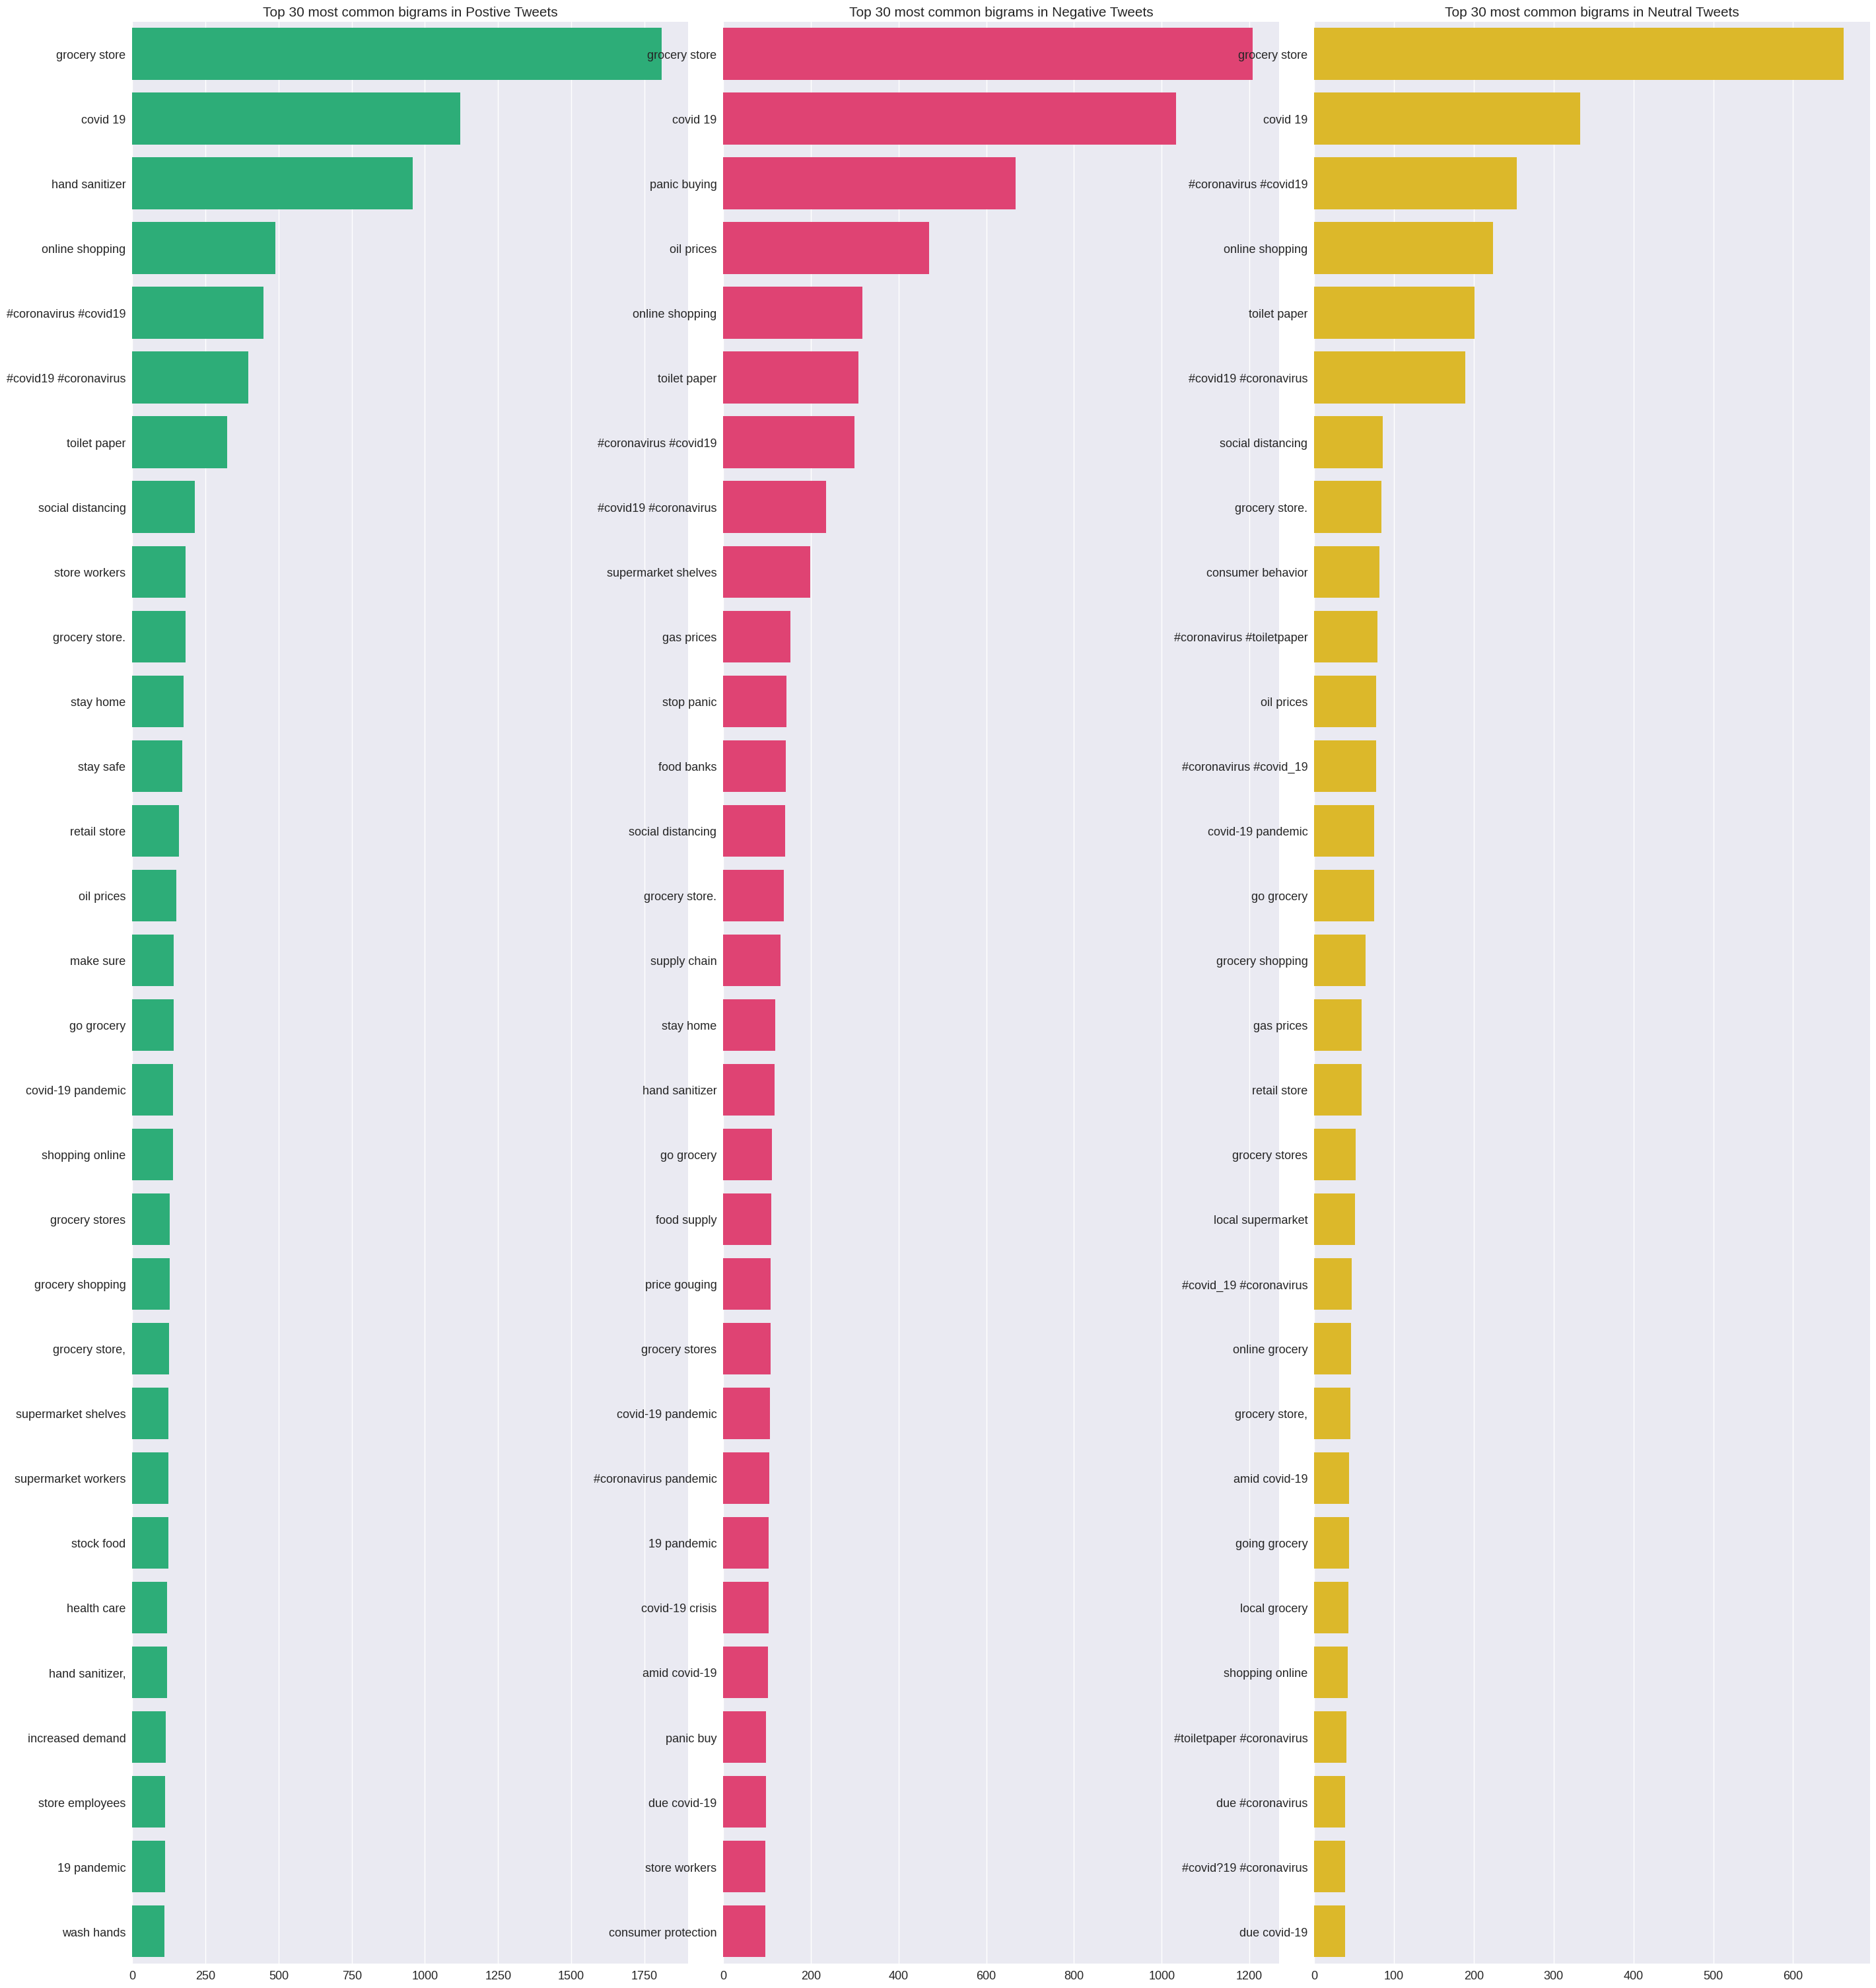

In [41]:
# Bigrams
positive_bigrams = defaultdict(int)
neutral_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        negative_bigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        neutral_bigrams[word] += 1        
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_bigrams = pd.DataFrame(sorted(neutral_bigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_bigrams[0].values[:N], x=df_neutral_bigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Neutral Tweets', fontsize=15)

plt.show()

# Tri-grams

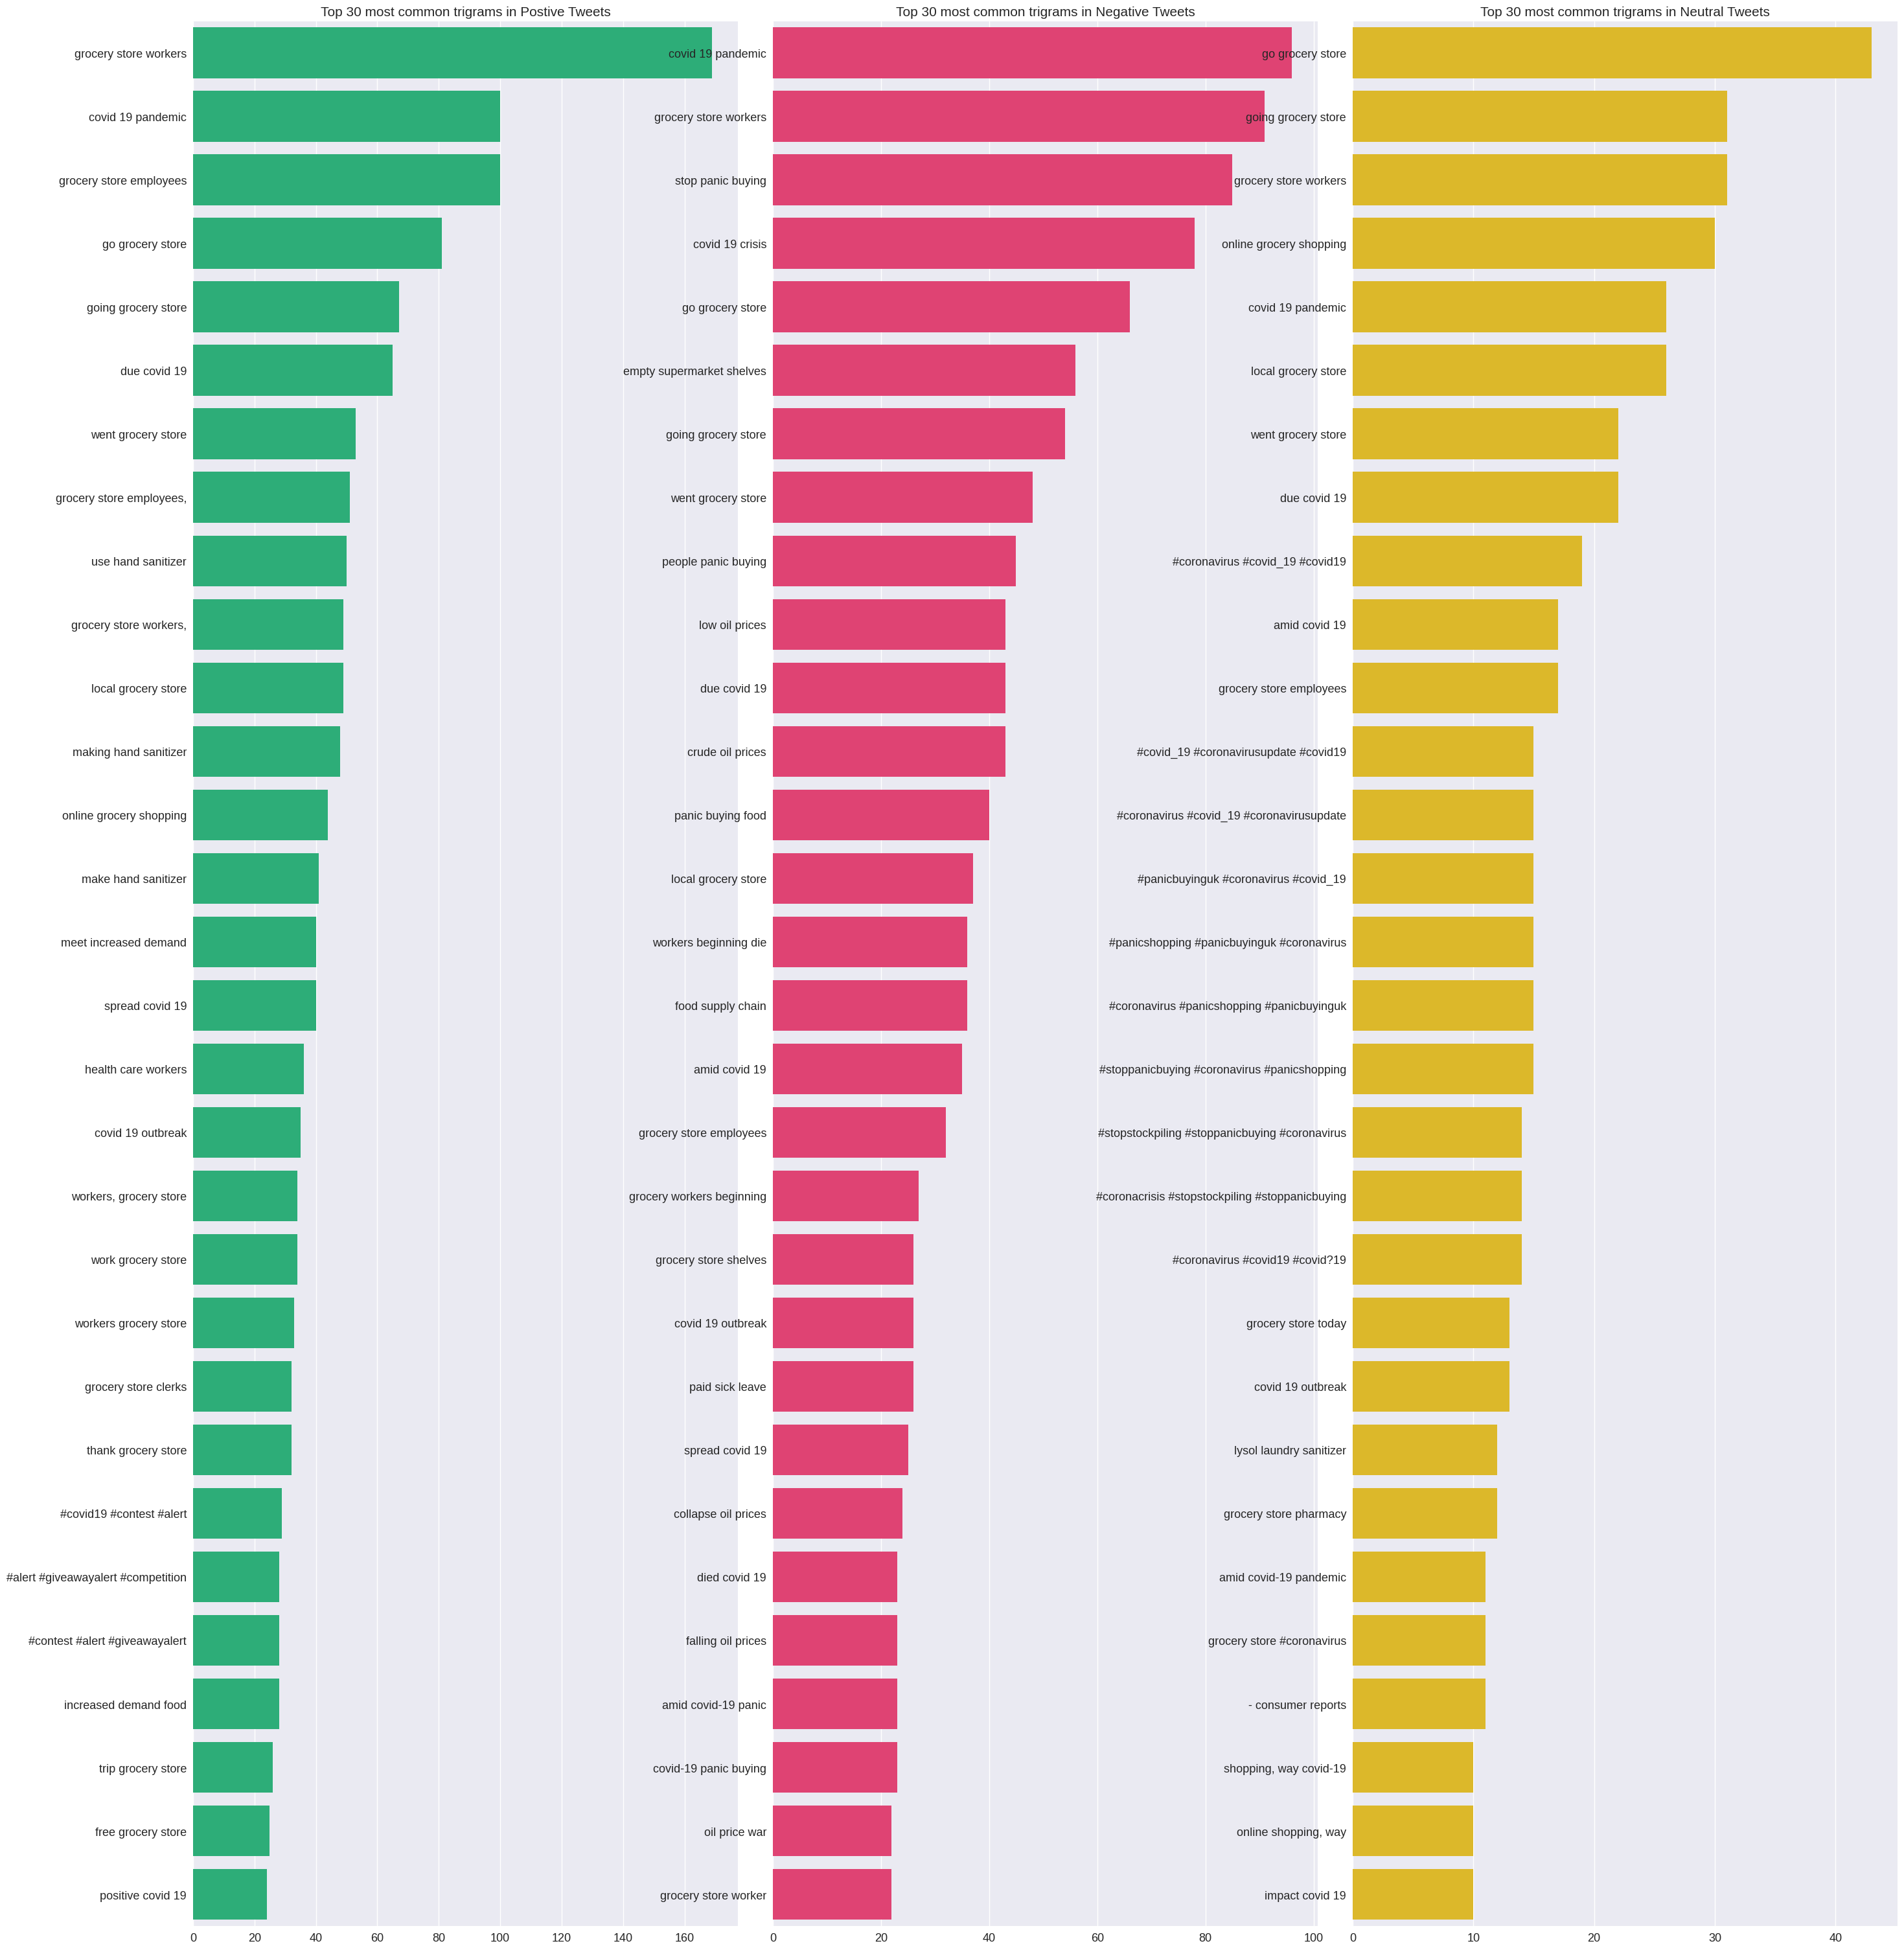

In [42]:
# Trigrams
positive_trigrams = defaultdict(int)
neutral_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        positive_trigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        negative_trigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        neutral_trigrams[word] += 1        
        
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_trigrams = pd.DataFrame(sorted(neutral_trigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_trigrams[0].values[:N], x=df_neutral_trigrams[1].values[:N], ax=axes[2], color='#FACA0C')




for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Neutral Tweets', fontsize=15)

plt.show()

<font size="+3" color="Green"><b>Future Work:</b></font>

<font size="+1" color="Black"><b>The modeling kernel notebook will soon be published here (link).
If you like my work then please leave an upvote, I am working professional (in data science and analytics) and take my time out to prepare these. Soon I will be preparing tutorials and notebooks on Market Mix Modeling which is seeing a rapid rise in the industry. 
You can also leave the suggestions in the comment box.
Happy learning. :)</b></font>


<font size="+3" color="Green"><b>Please Upvote if you liked the work</b></font>


![#Precious](https://i.imgur.com/5YSC6pg.gif)